## 1.数据预处理阶段

In [8]:
import numpy as np
from tqdm import tqdm
import pickle
fi_id_nfi_dict_path = "./data/fi_nfi_id.pkl"
feature_id_time_spatial_path = "./data/feature_id_time_spatial.pkl"
Best_label_cluster_path = "./processing/Best_label_cluster.pkl"


fi_id_nfi_dict = np.load(fi_id_nfi_dict_path, allow_pickle=True)
Best_label_cluster  = np.load(Best_label_cluster_path, allow_pickle=True)
print(Best_label_cluster)

{0: ['e076f2d4-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2d5-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2d7-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2d8-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2dc-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2e1-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2e3-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2e4-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2e5-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2ec-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2f2-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2f3-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2f6-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2f9-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f2fd-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f300-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f301-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f303-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f304-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f306-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f307-2552-11ea-9699-e0d55e6ff654-0.npy', 'e076f308-2552-11ea-9699-e0d5

## 2.频谱图的构建

### 2.1 频谱图功能测试

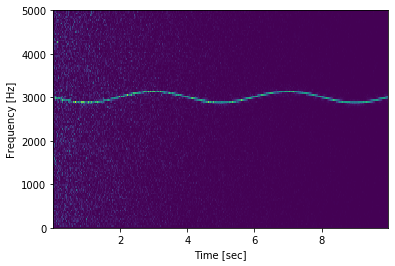

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

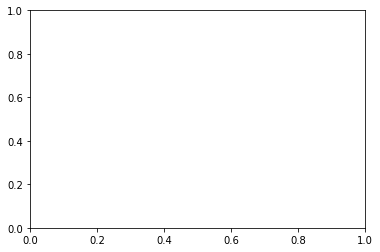

In [20]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
carrier_1 = amp * np.sin(2*np.pi*1000*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise
x_1 = carrier_1 + noise
f_1, t_1, sxx_1 = signal.spectrogram(x_1, fs)
f, t, Sxx = signal.spectrogram(x, fs)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.specgram(t_1, f_1)
plt.show()
